In [1]:
import os
import pathlib

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [23]:
pipeline_config = '../../models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'
model_dir = '../../models/tito_v03/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-93')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

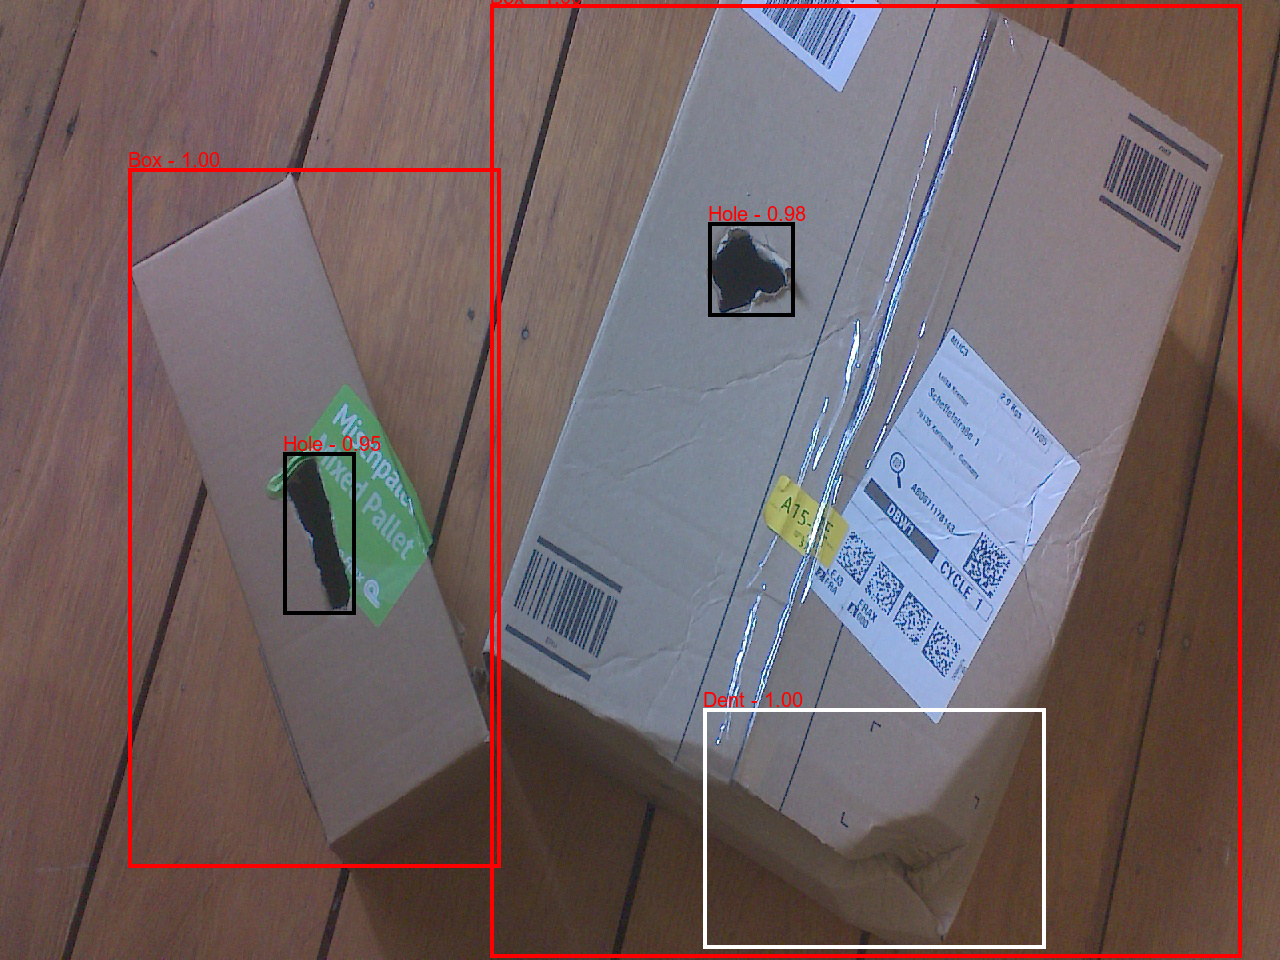

delta time:146 ms 
total time:146 ms 
total samples: 1 
avg delta time:146


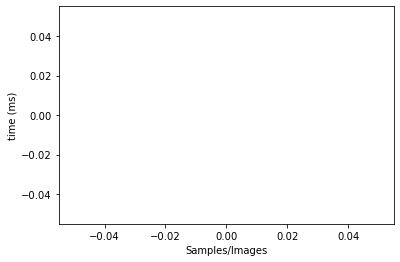

first duration: 146 ms


/opt/anaconda3/envs/aiss-cv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/aiss-cv/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [30]:
import time
from IPython.display import clear_output
total_time = 0.
delta_times = []
total_samples = 0
threshold = 0.5 # detection threshold
image_dir = '../../data/SET3_Done'
images = os.listdir(image_dir)
IMAGE_PATHS = [os.path.join(image_dir, i) for i in images if not 'json' in i]
cls_dict = {1: 'Box', 2:'Wet',4:'Hole' ,5:'Open', 3:'Dent'}
cls_color = {1: (255,0,0), 2:(0,0,255),4:(0,0,0) ,5:(0,255,0), 3:(255,255,255)}
for image_path in np.random.choice(IMAGE_PATHS, 1):
    img = Image.open(image_path)
    image_np = np.asarray(img)
    ### For the Visualization
    img_drawer = ImageDraw.Draw(img)

    # starting time
    time1 = time.monotonic()

    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)

    time1 = time.monotonic()
    # get the network output
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    rows = image_np.shape[0]
    cols = image_np.shape[1]
    #print(f'Rows: {rows}, cols: {cols}')
    ############################################
    # Get the number of detections 
    boxes = detections['detection_boxes'][0].numpy()
    classes = (detections['detection_classes'][0].numpy() + 1).astype(int)
    scores = detections['detection_scores'][0].numpy()
    num_detections = len(boxes)
    for i in range(num_detections):
        classId = classes[i]
        score = scores[i]
        bbox = boxes[i]
        if score > threshold:
            #print('Score: {}'.format(score))
            x = bbox[1] * cols  # xmin
            y = bbox[0] * rows  # ymin
            right = bbox[3] * cols # xmax
            bottom = bbox[2] * rows # ymax
            #print('Adding bounding box {}'.format([x,y,right,bottom]))
            thickness = int(rows/200)
            img_drawer.rectangle([x,y,right,bottom], outline =cls_color[classId], width=thickness)
            fnt = ImageFont.truetype("../../data/ARIAL.TTF", thickness*5)
            img_drawer.text((x, y-5*thickness), "{} - {:.2f}".format(cls_dict[classId], score), font=fnt, fill=cls_color[classId])

    time2 = time.monotonic()
    delta_time = (time2-time1)* 1000 # needed processing time for a sample in ms 
    delta_times.append(delta_time)
    total_time = total_time + delta_time
    total_samples = total_samples + 1
    avg_delta_time = total_time/total_samples

    clear_output(wait=True)
    # Uncomment here if you want to see the predictions
    display(img)
    time.sleep(5)
    print('delta time:{}'.format(round(delta_time)),'ms',
          '\n'  'total time:{}'.format(round(total_time)),'ms',
          '\n''total samples:',\
          round(total_samples), 
          '\n' 'avg delta time:{}'.format(round(avg_delta_time)))

plt.xlabel('Samples/Images')
plt.ylabel('time (ms)')
plt.plot(delta_times[1:])
plt.show()
print('first duration: {}'.format(round(delta_times[0])), 'ms')
# we are ignoring the first 10 since they need time to be loaded in the memory.
print('average process time without the first 10: {}.'.format(round(np.mean(delta_times[10:]))),'ms')
FPS = total_samples/(total_time)
print('FPS {}'.format(FPS * 1000))
print('FPS has been calculated using the total time.')